# Projeto - Mineração de Texto e Web
## Residência Engenharia e Ciência de dados - Samsung/UFPE

### Lucas Couri - lncc2
### Mariama Oliveira - mcso

## Carregando Dados

In [1]:
#Imports
import string
import nltk
from nltk.corpus import stopwords
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, f1_score

import numpy as np
import tensorflow as tf
#from keras.datasets import mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Conv2D, Input
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])


In [2]:
df = pd.read_csv("reviews_v2.csv")
df = df[df["reviews"].notna()]

In [3]:
df.head()


,reviews,stars,dates
0,Estou aqui para relatar uma experiência que ...,5,2021-06-05
1,"Já havia comprado a versão Lite, o que já ac...",5,2021-05-07
2,"Bom. Bem fluído, interessante e eficaz em cu...",5,2021-05-07
3,"Estou bem chateado, ja possuía o modelo anti...",3,2021-05-09
4,"Aparelho muito bom, está lidando muito bem c...",4,2021-05-06


In [4]:
df.dtypes

reviews    object
stars       int64
dates      object
dtype: object

## Pré-processamento (com e sem stemming)

In [5]:
#Global variables
other_punctuation = '—“”'  
stop_words = stopwords.words('portuguese')
stop_words.append('’')
stemmer = nltk.stem.RSLPStemmer()


#Function that removes punctuation 
def remove_punctuation(text):
    punctuation_free_doc = "".join([i for i in text if i not in string.punctuation+other_punctuation])
    return punctuation_free_doc


def remove_stopwords(list_words):
    filtered_words = [word for word in list_words if word not in stop_words]
    return filtered_words


def do_stemming(list_words):
    stem_text = [stemmer.stem(word) for word in list_words]
    return stem_text


def pre_process(doc, basic_processing = False, no_stopwords = False, stemming = False):

    final_doc = doc
    
    ## print(final_doc)

    if basic_processing == True:
        
        final_doc = remove_punctuation(doc)
        final_doc = final_doc.lower()

    final_doc = nltk.word_tokenize(final_doc)

    if no_stopwords == True:
        final_doc = remove_stopwords(final_doc)    

    if stemming == True:
        final_doc = do_stemming(final_doc)

    return final_doc

def pre_process_all(df, pre_processing_list):

    for param, index in zip(pre_processing_list, range(len(pre_processing_list))):
        
        df[f"reviews_pipeline_{index}"] = df["reviews"].apply(lambda x: pre_process(x, **param))

    return df

pre_processing_list = [
    {"basic_processing": True, "no_stopwords": True, "stemming": False},
    {"basic_processing": True, "no_stopwords": True, "stemming": True}]

df_pp = pre_process_all(df, pre_processing_list)

In [6]:
df_pp.head()

,reviews,stars,dates,reviews_pipeline_0,reviews_pipeline_1
0,Estou aqui para relatar uma experiência que ...,5,2021-06-05,"[aqui, relatar, experiência, visando, contribu...","[aqu, relat, experi, vis, contribu, amig, prob..."
1,"Já havia comprado a versão Lite, o que já ac...",5,2021-05-07,"[havia, comprado, versão, lite, achei, maravil...","[hav, compr, vers, lit, ach, maravilh, porém, ..."
2,"Bom. Bem fluído, interessante e eficaz em cu...",5,2021-05-07,"[bom, bem, fluído, interessante, eficaz, cumpr...","[bom, bem, flu, interess, eficaz, cumpr, prome..."
3,"Estou bem chateado, ja possuía o modelo anti...",3,2021-05-09,"[bem, chateado, ja, possuía, modelo, antigo, b...","[bem, chate, ja, possuí, model, antig, bem, co..."
4,"Aparelho muito bom, está lidando muito bem c...",4,2021-05-06,"[aparelho, bom, lidando, bem, home, tv, apenas...","[aparelh, bom, lid, bem, hom, tv, apen, porém,..."


In [7]:
df_pp[["reviews_pipeline_0", "reviews_pipeline_1"]]

,reviews_pipeline_0,reviews_pipeline_1
0,"[aqui, relatar, experiência, visando, contribu...","[aqu, relat, experi, vis, contribu, amig, prob..."
1,"[havia, comprado, versão, lite, achei, maravil...","[hav, compr, vers, lit, ach, maravilh, porém, ..."
2,"[bom, bem, fluído, interessante, eficaz, cumpr...","[bom, bem, flu, interess, eficaz, cumpr, prome..."
3,"[bem, chateado, ja, possuía, modelo, antigo, b...","[bem, chate, ja, possuí, model, antig, bem, co..."
4,"[aparelho, bom, lidando, bem, home, tv, apenas...","[aparelh, bom, lid, bem, hom, tv, apen, porém,..."
...,...,...
5002,"[chegou, super, rápido, atendeu, superou, toda...","[cheg, sup, rápid, atend, super, tod, expect]"
5003,"[facil, instalação, configuração, entrega, sup...","[facil, instal, configur, entreg, sup, rápid]"
5004,"[amei, produto, unico, problema, pra, mim, nao...","[ame, produt, unic, problem, pra, mim, nao, hbo]"
5005,"[funciona, beleza, rede, internet, sendo, boa,...","[func, bel, red, internet, send, boa, tud, bem]"


## Definindo classe

In [8]:
df_pp["class"] = df_pp["stars"].apply(lambda x : 1 if x >=4 else 0)

## Divisão train e test

In [9]:
X = df_pp[["reviews_pipeline_0", "reviews_pipeline_1"]]
y = df_pp["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [10]:
X_train.head()

,reviews_pipeline_0,reviews_pipeline_1
4688,"[chegou, antes, prazo, mostrou, excelente, pro...","[cheg, ant, praz, mostr, excel, produt, val, c..."
3802,"[melhor, produto, comprei, pra, tv, igual, fun...","[melhor, produt, compr, pra, tv, igual, func, ..."
4442,"[gostei, falta, globoplay, pra, mim, único, de...","[gost, falt, globoplay, pra, mim, únic, defeit..."
1146,"[fire, sitck, prático, funciona, bem, transfor...","[fir, sitck, prát, func, bem, transform, tv, c..."
4612,"[to, demais, super, fácil, praticovelocidade, ...","[to, demal, sup, fácil, praticoveloc, respost,..."


Transformando tokens em string

In [11]:
X_train_join = []
X_train_join.append(X_train["reviews_pipeline_0"].apply(" ".join))
X_train_join.append(X_train["reviews_pipeline_1"].apply(" ".join))
X_train_join[0] = X_train_join[0].to_numpy()
X_train_join[1] = X_train_join[1].to_numpy()

X_test_join = []
X_test_join.append(X_test["reviews_pipeline_0"].apply(" ".join))
X_test_join.append(X_test["reviews_pipeline_1"].apply(" ".join))
X_test_join[0] = X_test_join[0].to_numpy()
X_test_join[1] = X_test_join[1].to_numpy()

# Classificadores 

## Random Forest com BoW

In [12]:
vectorizer = CountVectorizer(analyzer = "word",   
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,   
                             max_features = 2000) 

#List with BoWs (pipeline 0 and 1)
X_train_vec = []
X_train_vec.append(vectorizer.fit_transform(X_train_join[0]))
X_train_vec.append(vectorizer.fit_transform(X_train_join[1]))

X_test_vec = []
X_test_vec.append(vectorizer.fit_transform(X_test_join[0]))
X_test_vec.append(vectorizer.fit_transform(X_test_join[1]))


print(X_train_vec[0].shape)

(3502, 2000)


### Sem stemming

In [13]:
forest = RandomForestClassifier() 
forest = forest.fit(X_train_vec[0], y_train)

In [14]:
predictions = forest.predict(X_test_vec[0]) 
result = forest.predict(X_test_vec[0])
print(classification_report(y_test, result))


              precision    recall  f1-score   support

           0       0.15      0.09      0.11       170
           1       0.89      0.94      0.91      1331

    accuracy                           0.84      1501
   macro avg       0.52      0.51      0.51      1501
weighted avg       0.81      0.84      0.82      1501



Matriz de Confusão

In [15]:
confusion_matrix(y_test, result)

array([[  15,  155],
       [  84, 1247]], dtype=int64)

### Com Stemming

In [16]:
forest = RandomForestClassifier() 
forest = forest.fit(X_train_vec[1], y_train)

In [17]:
predictions = forest.predict(X_test_vec[1]) 
result = forest.predict(X_test_vec[1])
print(classification_report(y_test, result))


              precision    recall  f1-score   support

           0       0.28      0.13      0.18       170
           1       0.90      0.96      0.93      1331

    accuracy                           0.86      1501
   macro avg       0.59      0.54      0.55      1501
weighted avg       0.83      0.86      0.84      1501



In [18]:
confusion_matrix(y_test, result)

array([[  22,  148],
       [  58, 1273]], dtype=int64)

## Redes (CNN, LSTM e BERT)

In [19]:
# tf.keras.layers.TextVectorization(
#     max_tokens=None,
#     standardize='lower_and_strip_punctuation',
#     split='whitespace',
#     ngrams=None,
#     output_mode='int',
#     output_sequence_length=None,
#     pad_to_max_tokens=False,
#     vocabulary=None,
#     idf_weights=None,
#     sparse=False,
#     ragged=False,
#     **kwargs
# )

In [20]:
X_train_join[0]

array(['chegou antes prazo mostrou excelente produto vale compra',
       'melhor produto comprei pra tv igual funciona bem',
       'gostei falta globoplay pra mim único defeito momento', ...,
       'atendeu todas expectativas ótimo produto fácil instalação controle prático funciona perfeitamente',
       'funcionou tv sansung usar tv smart atendeu',
       'comprei pra dar upgrade tv ameinão fácil instalar tudo intuitivo rápidoestou amando'],
      dtype=object)

### Encoder (Sem stemming)

In [139]:
VOCAB_SIZE = 1000
encoder_0 = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE,
                                            standardize=None
                                            )
#encoder.adapt(train_dataset.map(lambda text, label: text))
encoder_0.adapt(X_train_join[0])


In [140]:
vectorized_text = encoder_0(X_train_join[0])
print(vectorized_text)

tf.Tensor(
[[ 45  67 155 ...   0   0   0]
 [ 31   3  37 ...   0   0   0]
 [ 26  52  34 ...   0   0   0]
 ...
 [ 99  93  54 ...   0   0   0]
 [ 84   2   1 ...   0   0   0]
 [ 37  23 269 ...   0   0   0]], shape=(3502, 180), dtype=int64)


In [141]:
vocab = np.array(encoder_0.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'tv', 'produto', 'controle', 'fácil', 'bem', 'bom',
       'alexa', 'instalar', 'fire', 'stick', 'aparelho', 'smart',
       'excelente', 'amazon', 'instalação', 'hbo', 'rápido', 'recomendo'],
      dtype='<U17')

### Encoder (Com stemming)

In [136]:
VOCAB_SIZE = 1000
encoder_1 = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE,
                                            standardize=None
                                            )
#encoder.adapt(train_dataset.map(lambda text, label: text))
encoder_1.adapt(X_train_join[1])


In [137]:
vectorized_text = encoder_1(X_train_join[1])
print(vectorized_text)

tf.Tensor(
[[ 44  90 164 ...   0   0   0]
 [ 29   3   8 ...   0   0   0]
 [ 21  53  43 ...   0   0   0]
 ...
 [ 55  20  68 ...   0   0   0]
 [ 22   2   1 ...   0   0   0]
 [  8  27 262 ...   0   0   0]], shape=(3502, 180), dtype=int64)


In [138]:
vocab = np.array(encoder_1.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'tv', 'produt', 'instal', 'control', 'fácil', 'bem',
       'compr', 'alex', 'bom', 'fir', 'app', 'rápid', 'aparelh', 'ótim',
       'aplic', 'stick', 'smart', 'us'], dtype='<U13')

### CNN

#### Sem stemming

In [189]:
model_CNN_0 = tf.keras.Sequential([
    encoder_0,
    tf.keras.layers.Embedding(
        input_dim=len(encoder_0.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu'),
    tf.keras.layers.MaxPool1D(pool_size=2),
    #tf.keras.layers.Flatten(),    
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [182]:
print(model_CNN_0.summary())

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_18 (Embedding)    (None, None, 64)          64000     
                                                                 
 conv1d_8 (Conv1D)           (None, None, 32)          16416     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, None, 32)         0         
 1D)                                                             
                                                                 
 dense_34 (Dense)            (None, None, 32)          1056      
                                                                 
 global_max_pooling1d_3 (Glo  (None, 32)             

In [190]:
model_CNN_0.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [191]:
history = model_CNN_0.fit(X_train_join[0], y_train, epochs=30,
                    batch_size = 32,
                    validation_data= (X_test_join[0], y_test),
                    validation_steps=30
                    )

Epoch 1/30


C:\Users\lucas\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


110/110 [==============================] - 2s 13ms/step - loss: 0.6675 - accuracy: 0.7010 - val_loss: 0.6115 - val_accuracy: 0.8854
Epoch 2/30
110/110 [==============================] - 1s 11ms/step - loss: 0.5227 - accuracy: 0.8898 - val_loss: 0.4293 - val_accuracy: 0.8854
Epoch 3/30
110/110 [==============================] - 1s 11ms/step - loss: 0.3747 - accuracy: 0.8898 - val_loss: 0.3632 - val_accuracy: 0.8854
Epoch 4/30
110/110 [==============================] - 1s 11ms/step - loss: 0.3466 - accuracy: 0.8898 - val_loss: 0.3612 - val_accuracy: 0.8854
Epoch 5/30
110/110 [==============================] - 1s 11ms/step - loss: 0.3453 - accuracy: 0.8898 - val_loss: 0.3605 - val_accuracy: 0.8854
Epoch 6/30
110/110 [==============================] - 1s 11ms/step - loss: 0.3438 - accuracy: 0.8898 - val_loss: 0.3597 - val_accuracy: 0.8854
Epoch 7/30
110/110 [==============================] - 1s 11ms/step - loss: 0.3415 - accuracy: 0.8898 - val_loss: 0.3586 - val_accuracy: 0.8854
Epoch 8/30

In [192]:
test_loss, test_acc = model_CNN_0.evaluate(X_test_join[0], y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

47/47 [==============================] - 0s 4ms/step - loss: 0.2763 - accuracy: 0.9007
Test Loss: 0.2762574851512909
Test Accuracy: 0.9007328152656555


In [193]:
result = model_CNN_0.predict(X_test_join[0])
result = np.where(result > 0.5, 1, 0)
result

print(classification_report(y_test, result))

              precision    recall  f1-score   support

           0       0.59      0.40      0.48       170
           1       0.93      0.96      0.95      1331

    accuracy                           0.90      1501
   macro avg       0.76      0.68      0.71      1501
weighted avg       0.89      0.90      0.89      1501



In [194]:
confusion_matrix(y_test, result)

array([[  68,  102],
       [  47, 1284]], dtype=int64)

(0.0, 0.6964673478156328)

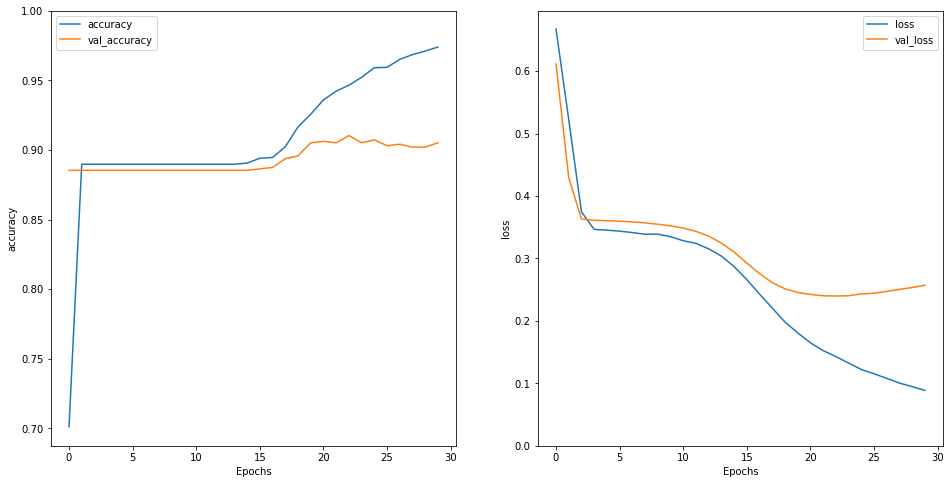

In [195]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

#### Com stemming

In [196]:
model_CNN_1 = tf.keras.Sequential([
    encoder_1,
    tf.keras.layers.Embedding(
        input_dim=len(encoder_1.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu'),
    tf.keras.layers.MaxPool1D(pool_size=2),
    #tf.keras.layers.Flatten(),    
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [197]:
print(model_CNN_1.summary())

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_20 (Embedding)    (None, None, 64)          64000     
                                                                 
 conv1d_10 (Conv1D)          (None, None, 32)          16416     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, None, 32)         0         
 g1D)                                                            
                                                                 
 dense_38 (Dense)            (None, None, 32)          1056      
                                                                 
 global_max_pooling1d_5 (Glo  (None, 32)             

In [198]:
model_CNN_1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [199]:
history = model_CNN_1.fit(X_train_join[1], y_train, epochs=20,
                    batch_size = 32,
                    validation_data= (X_test_join[1], y_test),
                    validation_steps=3
                    )

Epoch 1/20


C:\Users\lucas\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


110/110 [==============================] - 2s 12ms/step - loss: 0.5819 - accuracy: 0.8898 - val_loss: 0.4693 - val_accuracy: 0.9062
Epoch 2/20
110/110 [==============================] - 1s 11ms/step - loss: 0.3917 - accuracy: 0.8898 - val_loss: 0.3365 - val_accuracy: 0.9062
Epoch 3/20
110/110 [==============================] - 1s 10ms/step - loss: 0.3436 - accuracy: 0.8898 - val_loss: 0.3309 - val_accuracy: 0.9062
Epoch 4/20
110/110 [==============================] - 1s 11ms/step - loss: 0.3438 - accuracy: 0.8898 - val_loss: 0.3302 - val_accuracy: 0.9062
Epoch 5/20
110/110 [==============================] - 1s 11ms/step - loss: 0.3427 - accuracy: 0.8898 - val_loss: 0.3294 - val_accuracy: 0.9062
Epoch 6/20
110/110 [==============================] - 1s 10ms/step - loss: 0.3439 - accuracy: 0.8898 - val_loss: 0.3279 - val_accuracy: 0.9062
Epoch 7/20
110/110 [==============================] - 1s 11ms/step - loss: 0.3423 - accuracy: 0.8898 - val_loss: 0.3268 - val_accuracy: 0.9062
Epoch 8/20

In [200]:
test_loss, test_acc = model_CNN_1.evaluate(X_test_join[1], y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

47/47 [==============================] - 0s 3ms/step - loss: 0.2356 - accuracy: 0.8987
Test Loss: 0.23556622862815857
Test Accuracy: 0.8987341523170471


In [201]:
result = model_CNN_0.predict(X_test_join[1])
result = np.where(result > 0.5, 1, 0)
result

print(classification_report(y_test, result))


              precision    recall  f1-score   support

           0       0.35      0.26      0.30       170
           1       0.91      0.94      0.92      1331

    accuracy                           0.86      1501
   macro avg       0.63      0.60      0.61      1501
weighted avg       0.85      0.86      0.85      1501



In [202]:
confusion_matrix(y_test, result)

array([[  45,  125],
       [  84, 1247]], dtype=int64)

(0.0, 0.6022473722696304)

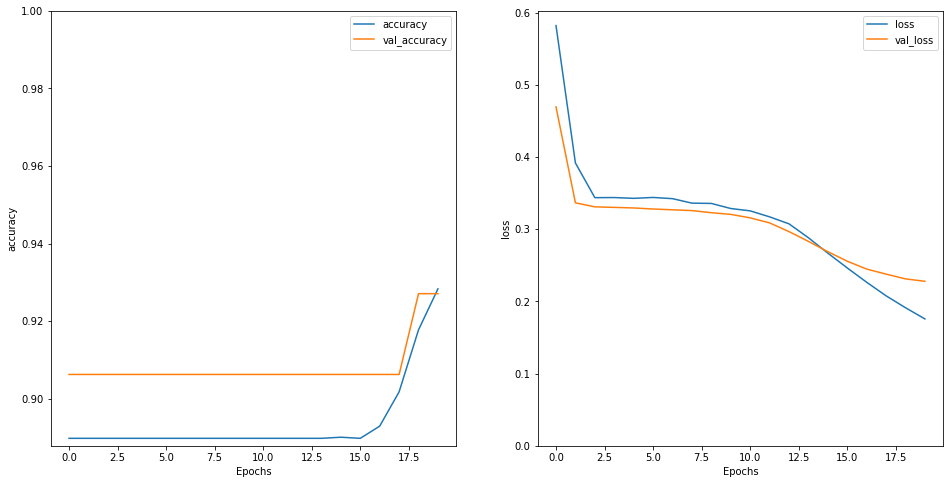

In [203]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

### LSTM

In [127]:
model_LSTM0 = tf.keras.Sequential([
    encoder_0,
    tf.keras.layers.Embedding(
        input_dim=len(encoder_0.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [128]:
model_LSTM0.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [153]:
print(model_LSTM0.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_9 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional_9 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 138,369
Trainable params: 138,369
Non-tr

#### Sem stemming

Treinando modelo

In [129]:
history = model_LSTM0.fit(X_train_join[0], y_train, epochs=20,
                    batch_size = 32,
                    validation_data= (X_test_join[0], y_test),
                    validation_steps=30
                    )

Epoch 1/20


C:\Users\lucas\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


110/110 [==============================] - 17s 99ms/step - loss: 0.6236 - accuracy: 0.8607 - val_loss: 0.4794 - val_accuracy: 0.8854
Epoch 2/20
110/110 [==============================] - 8s 75ms/step - loss: 0.4170 - accuracy: 0.8898 - val_loss: 0.3741 - val_accuracy: 0.8854
Epoch 3/20
110/110 [==============================] - 8s 74ms/step - loss: 0.3380 - accuracy: 0.8898 - val_loss: 0.3239 - val_accuracy: 0.8854
Epoch 4/20
110/110 [==============================] - 8s 74ms/step - loss: 0.2951 - accuracy: 0.8898 - val_loss: 0.2898 - val_accuracy: 0.8854
Epoch 5/20
110/110 [==============================] - 8s 75ms/step - loss: 0.2576 - accuracy: 0.8926 - val_loss: 0.2571 - val_accuracy: 0.8906
Epoch 6/20
110/110 [==============================] - 9s 77ms/step - loss: 0.2229 - accuracy: 0.9063 - val_loss: 0.2471 - val_accuracy: 0.8938
Epoch 7/20
110/110 [==============================] - 9s 78ms/step - loss: 0.1973 - accuracy: 0.9258 - val_loss: 0.2418 - val_accuracy: 0.8979
Epoch 8/2

Avaliando modelo

In [134]:
test_loss, test_acc = model_LSTM0.evaluate(X_test_join[0], y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

47/47 [==============================] - 1s 26ms/step - loss: 0.4435 - accuracy: 0.8854
Test Loss: 0.4434678554534912
Test Accuracy: 0.8854097127914429


In [135]:
result = model_LSTM0.predict(X_test_join[0])
result = np.where(result > 0.5, 1, 0)
result

print(classification_report(y_test, result))

              precision    recall  f1-score   support

           0       0.49      0.46      0.48       170
           1       0.93      0.94      0.94      1331

    accuracy                           0.89      1501
   macro avg       0.71      0.70      0.71      1501
weighted avg       0.88      0.89      0.88      1501



In [132]:
confusion_matrix(y_test, result)

array([[  78,   92],
       [  80, 1251]], dtype=int64)

(0.0, 0.6511498056352139)

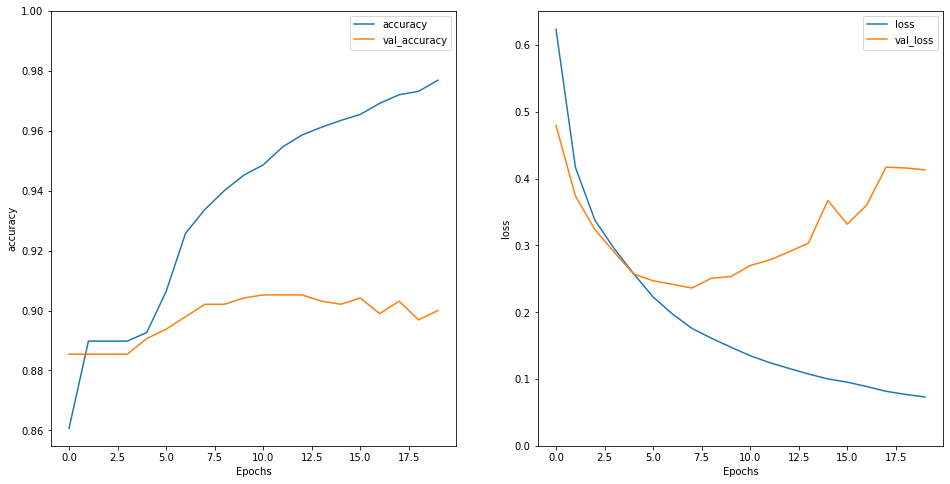

In [133]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

#### Com stemming

In [ ]:
model_LSTM1 = tf.keras.Sequential([
    encoder_1,
    tf.keras.layers.Embedding(
        input_dim=len(encoder_1.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model_LSTM1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

Treinando modelo

In [105]:
history = model_LSTM1.fit(X_train_join[1], y_train, epochs=10,
                    batch_size = 32,
                    validation_data= (X_test_join[1], y_test),
                    validation_steps=30
                    )

Epoch 1/10
110/110 [==============================] - 8s 72ms/step - loss: 0.2992 - accuracy: 0.8841 - val_loss: 0.3168 - val_accuracy: 0.8750
Epoch 2/10
110/110 [==============================] - 7s 66ms/step - loss: 0.2815 - accuracy: 0.8909 - val_loss: 0.3172 - val_accuracy: 0.8854
Epoch 3/10
110/110 [==============================] - 8s 70ms/step - loss: 0.2771 - accuracy: 0.8932 - val_loss: 0.3206 - val_accuracy: 0.8656
Epoch 4/10
110/110 [==============================] - 7s 65ms/step - loss: 0.2766 - accuracy: 0.8912 - val_loss: 0.3253 - val_accuracy: 0.8865
Epoch 5/10
110/110 [==============================] - 7s 65ms/step - loss: 0.2733 - accuracy: 0.8943 - val_loss: 0.3140 - val_accuracy: 0.8708
Epoch 6/10
110/110 [==============================] - 7s 65ms/step - loss: 0.2712 - accuracy: 0.8941 - val_loss: 0.3252 - val_accuracy: 0.8656
Epoch 7/10
110/110 [==============================] - 7s 67ms/step - loss: 0.2689 - accuracy: 0.8955 - val_loss: 0.3138 - val_accuracy: 0.8771

Avaliando modelo

In [106]:
test_loss, test_acc = model_LSTM1.evaluate(X_test_join[1], y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

47/47 [==============================] - 1s 21ms/step - loss: 0.3092 - accuracy: 0.8761
Test Loss: 0.3092056214809418
Test Accuracy: 0.8760825991630554


In [107]:
result = model_LSTM1.predict(X_test_join[1])
result = np.where(result > 0.5, 1, 0)
result

print(classification_report(y_test, result))

              precision    recall  f1-score   support

           0       0.37      0.14      0.20       170
           1       0.90      0.97      0.93      1331

    accuracy                           0.88      1501
   macro avg       0.63      0.55      0.57      1501
weighted avg       0.84      0.88      0.85      1501



In [108]:
confusion_matrix(y_test, result)

array([[  23,  147],
       [  39, 1292]], dtype=int64)

(0.0, 0.3284050300717354)

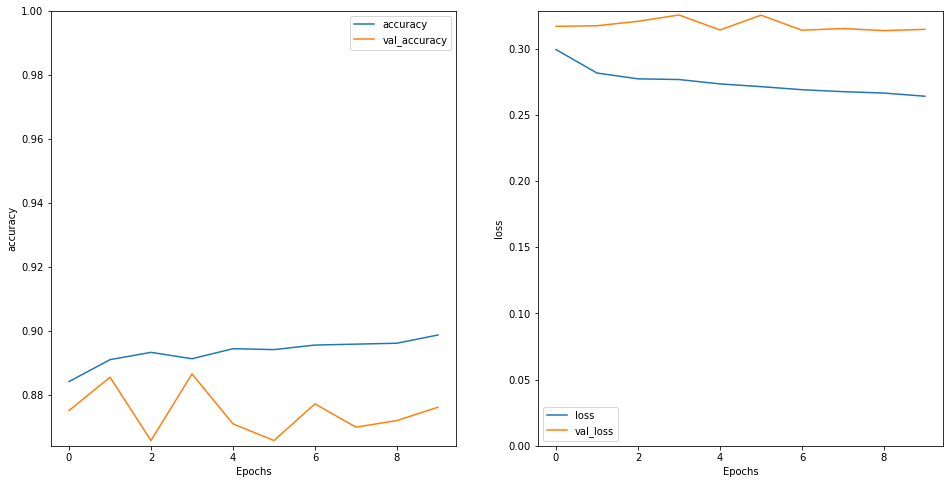

In [109]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

### BERT

In [204]:
from transformers import BertTokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
def convert_example_to_feature(review):
  return tokenizer.encode_plus(review,
                add_special_tokens = True, # add [CLS], [SEP]
                max_length = max_length, # max length of the text that can go to BERT
                pad_to_max_length = True, # add [PAD] tokens
                return_attention_mask = True, # add attention mask to not focus on pad tokens
              )

In [ ]:
# can be up to 512 for BERT
max_length = 512
batch_size = 6

In [ ]:
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label

In [ ]:
def encode_examples(ds, limit=-1):
  # prepare list, so that we can build up final TensorFlow dataset from slices.
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []
  if (limit > 0):
      ds = ds.take(limit)
  for review, label in tfds.as_numpy(ds):
    bert_input = convert_example_to_feature(review.decode())
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([label])
  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

In [ ]:
# train dataset
ds_train_encoded = encode_examples(ds_train).shuffle(10000).batch(batch_size)
# test dataset
ds_test_encoded = encode_examples(ds_test).batch(batch_size)

In [ ]:
from transformers import TFBertForSequenceClassification
import tensorflow as tf
# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 2e-5
# we will do just 1 epoch, though multiple epochs might be better as long as we will not overfit the model
number_of_epochs = 1
# model initialization
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

In [ ]:
# choosing Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
bert_history = model.fit(ds_train_encoded, epochs=number_of_epochs, validation_data=ds_test_encoded)

In [ ]:
test_sentence = "This is a really good movie. I loved it and will watch again"

predict_input = tokenizer.encode(test_sentence,

truncation=True,

padding=True,

return_tensors="tf")

In [ ]:
tf_output = model.predict(predict_input)[0]
tf_prediction = tf.nn.softmax(tf_output, axis=1)
labels = ['Negative','Positive'] #(0:negative, 1:positive)
label = tf.argmax(tf_prediction, axis=1)
label = label.numpy()
print(labels[label[0]])